# LSTM on Donors choose data

In [244]:
!gdown --id 1pGd5tLwA30M7wkbJKdXHaae9tYVDICJ_

Downloading...
From: https://drive.google.com/uc?id=1pGd5tLwA30M7wkbJKdXHaae9tYVDICJ_
To: /content/glove_vectors
100% 128M/128M [00:01<00:00, 86.6MB/s]


# <font color='red'> Model-1 </font>

In [205]:
# import all the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import tensorflow
from tensorflow.keras.layers import Input,Dense,LSTM

In [5]:
#read the csv file
df = pd.read_csv('preprocessed_data.csv')

In [6]:
df

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74
...,...,...,...,...,...,...,...,...,...
109243,hi,mrs,grades_9_12,5,1,health_sports,teamsports,our day starts 100 students athletes low incom...,143.36
109244,nm,ms,grades_prek_2,3,1,appliedlearning,earlydevelopment other,my students range age four five years old atte...,268.57
109245,il,mrs,grades_3_5,0,1,math_science,appliedsciences environmentalscience,we title 1 school 650 total students our eleme...,399.00
109246,hi,mrs,grades_9_12,1,1,math_science,health_lifescience,i teach many different types students my class...,287.73


In [7]:
y = df['project_is_approved'].values
X = df.drop(['project_is_approved'], axis=1)

In [202]:
# perform stratified train test split on the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=15, stratify=y)

## 1.1 Text Vectorization

In [143]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def vectorization(sentences_train, sentences_test): # function for vectorization of text data
    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(sentences_train)

    vocab_size = len(tokenizer.index_word)

    sequences_train = tokenizer.texts_to_sequences(sentences_train)
    sequences_test = tokenizer.texts_to_sequences(sentences_test)

    sequence_lengths = [len(i) for i in sequences_train]
    pad_length = max(sequence_lengths)

    train_padded_docs=pad_sequences(sequences_train,maxlen=pad_length)
    test_padded_docs = pad_sequences(sequences_test,maxlen=pad_length)

    return vocab_size,pad_length,train_padded_docs,test_padded_docs,tokenizer

In [208]:
#vectorization of the text data
vocab_size,pad_length,train_padded_docs,test_padded_docs,tokenizer = vectorization(X_train['essay'].values,X_test['essay'].values)

In [209]:
print("Vocabulary_size = ",vocab_size)
print("Padding_length = ",pad_length)
print("\nTrain_text_padded_sequences_shape = \n\n",train_padded_docs)
print("\nTest_text_padded_sequences_shape = \n\n",test_padded_docs)

Vocabulary_size =  48267
Padding_length =  339

Train_text_padded_sequences_shape = 

 [[   0    0    0 ...  123   84   14]
 [   0    0    0 ... 2994  189   14]
 [   0    0    0 ...  263  458   14]
 ...
 [   0    0    0 ...  717  643   14]
 [   0    0    0 ... 4131 3944   14]
 [   0    0    0 ...  217   57   14]]

Test_text_padded_sequences_shape = 

 [[   0    0    0 ...    6  176   14]
 [   0    0    0 ...  335  469   14]
 [   0    0    0 ... 1662  341   14]
 ...
 [   0    0    0 ... 1121   17   14]
 [   0    0    0 ...   37   37   14]
 [   0    0    0 ...   62  351   14]]


In [210]:
import pickle
with open('glove_vectors', 'rb') as f:
    glove_dict = pickle.load(f)
    glove_words =  set(glove_dict.keys())

In [211]:
#Embedding Matrix
embedding_matrix_model_1 = np.zeros((vocab_size+1,300))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_model_1[i] = embedding_vector

In [212]:
embedding_matrix_model_1.shape

(48268, 300)

## 1.2 Categorical feature Vectorization

In [213]:
#label-encoding the categorical features
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(handle_unknown = 'use_encoded_value',unknown_value = 385)
column_train_data = enc.fit_transform(X_train[['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories']])
column_test_data = enc.transform(X_test[['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories']])

## 1.3 Numerical feature Vectorization

In [215]:
#Standardizing the numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_data_train = scaler.fit_transform(X_train[['teacher_number_of_previously_posted_projects','price']])
numerical_data_test = scaler.transform(X_test[['teacher_number_of_previously_posted_projects','price']])

## 1.4 Defining the model

In [219]:
#defining variables for the model
school_state_categories = len(X_train['school_state'].unique())
project_grade_categories = len(X_train['project_grade_category'].unique())
clean_categories = len(X_train['clean_categories'].unique())
clean_subcategories = len(X_train['clean_subcategories'].unique())
teacher_prefix_categories = len(X_train['teacher_prefix'].unique())
unseen_encoded_value = 385
embedding_output = embedding_matrix_model_1.shape[1]

In [226]:
#defining the model
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Embedding,LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import datetime

inputs_text = Input(shape=(pad_length,))
embedding_text = Embedding(vocab_size+1, embedding_output,weights=[embedding_matrix_model_1],trainable=False)(inputs_text)
lstm = LSTM(4)(embedding_text)
flat_text = Flatten()(lstm)

input_school_state = Input(shape=(1,)) #input shape '1' because dataset has only one column
embedding_school_state = Embedding(school_state_categories, 2,trainable=True)(input_school_state)
flat_school_state = Flatten()(embedding_school_state)

input_project_grade = Input(shape=(1,))
embedding_project_grade = Embedding(project_grade_categories, 2,trainable=True)(input_project_grade)
flat_project_grade = Flatten()(embedding_project_grade)

input_clean_categories = Input(shape=(1,))
embedding_clean_categories = Embedding(unseen_encoded_value + 1, 2,trainable=True)(input_clean_categories)
flat_clean_categories = Flatten()(embedding_clean_categories)

input_clean_subcategories = Input(shape=(1,))
embedding_clean_subcategories = Embedding(unseen_encoded_value + 1, 2,trainable=True)(input_clean_subcategories)
flat_clean_subcategories = Flatten()(embedding_clean_subcategories)

input_teacher_prefix = Input(shape=(1,))
embedding_teacher_prefix = Embedding(teacher_prefix_categories, 2,trainable=True)(input_teacher_prefix)
flat_teacher_prefix = Flatten()(embedding_teacher_prefix)

input_numerical = Input(shape=(2,))
dense = Dense(4, activation='relu')(input_numerical)

concat = concatenate([flat_text, flat_school_state, flat_project_grade,flat_clean_categories,flat_clean_subcategories,flat_teacher_prefix,dense])

dense1 = Dense(256, activation='relu')(concat)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(256, activation='relu')(drop1)
drop2 = Dropout(0.5)(dense2)
dense3 = Dense(256, activation='relu')(drop2)

outputs = Dense(1, activation='sigmoid')(dense3)
model_1 = Model(inputs=[inputs_text,input_school_state,input_project_grade,input_clean_categories,input_clean_subcategories,input_teacher_prefix,input_numerical], outputs=outputs)


In [221]:
model_1.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 339)]        0           []                               
                                                                                                  
 embedding_28 (Embedding)       (None, 339, 300)     14480400    ['input_38[0][0]']               
                                                                                                  
 input_39 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

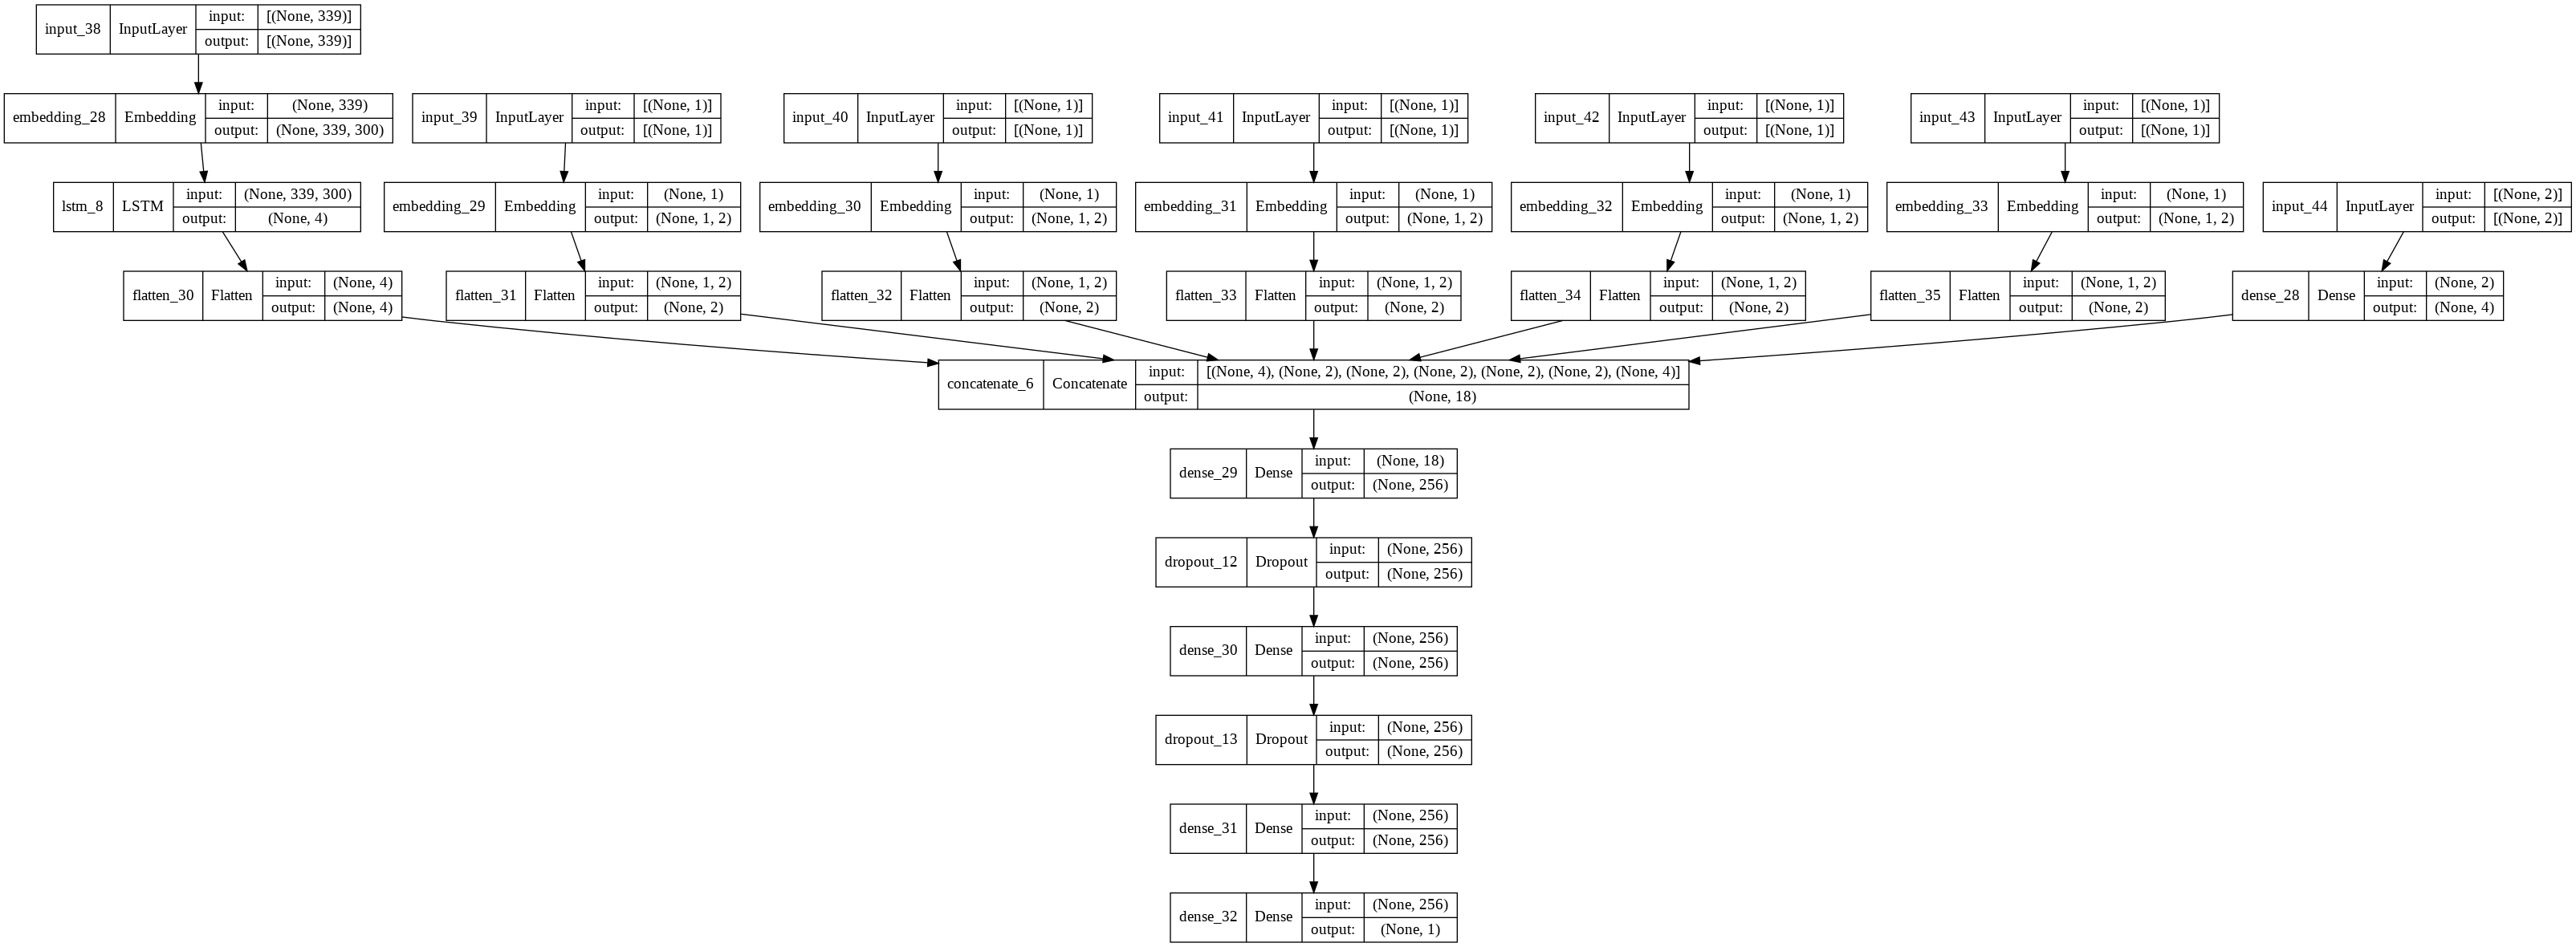

In [222]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model_1, to_file=dot_img_file, show_shapes=True)

## 1.5 Compiling and fititng your model

In [227]:
#custom auc metric
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.double)

In [228]:
#compiling and fitting the model
train_data = [train_padded_docs,column_train_data[:,0],column_train_data[:,2],column_train_data[:,3],column_train_data[:,4],column_train_data[:,1],numerical_data_train]
val_data = [test_padded_docs,column_test_data[:,0],column_test_data[:,2],column_test_data[:,3],column_test_data[:,4],column_test_data[:,1],numerical_data_test]

filepath="model_save/best_model_1.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_auc',  verbose=1, save_best_only=True, mode='max')

log_dir="logs\\fit\\Model_1_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

model_1.compile(loss='binary_crossentropy', optimizer='Adam',metrics = [auc])
model_1.fit(train_data,y_train,epochs=3, validation_data=(val_data,y_test), batch_size=64, callbacks=[checkpoint,tensorboard_callback])

Epoch 1/3
1144/1144 [==============================] - ETA: 0s - loss: 0.4161 - auc: 0.6197
Epoch 00001: val_auc improved from -inf to 0.71743, saving model to model_save/best_model_1.hdf5
1144/1144 [==============================] - 222s 191ms/step - loss: 0.4161 - auc: 0.6197 - val_loss: 0.3849 - val_auc: 0.7174
Epoch 2/3
1144/1144 [==============================] - ETA: 0s - loss: 0.3802 - auc: 0.7286
Epoch 00002: val_auc improved from 0.71743 to 0.73921, saving model to model_save/best_model_1.hdf5
1144/1144 [==============================] - 227s 199ms/step - loss: 0.3802 - auc: 0.7286 - val_loss: 0.3719 - val_auc: 0.7392
Epoch 3/3
1144/1144 [==============================] - ETA: 0s - loss: 0.3706 - auc: 0.7468
Epoch 00003: val_auc improved from 0.73921 to 0.75277, saving model to model_save/best_model_1.hdf5
1144/1144 [==============================] - 223s 195ms/step - loss: 0.3706 - auc: 0.7468 - val_loss: 0.3655 - val_auc: 0.7528


Observations:
1. val_auc score crossed 0.75 within 3 epochs
2. convergence took less epochs because we used mini-batch size as 64
3. At the end of final epoch val_auc score is greater than train_auc score.
4. Best val_auc score is 0.7528
5. val_loss is the lowest of the 3 models, i.e 0.3655
5. The model is not overfitting

# <font color='red'> Model-2 </font>

In [203]:
# Tfidf vectorization of the training input text data
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf = True)
X_train_tfidf = vectorizer.fit_transform(X_train['essay'].values)

Text(0, 0.5, 'idf values')

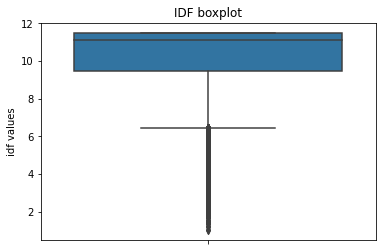

In [207]:
# box-plot of idf values
sns.boxplot(y = vectorizer.idf_)
plt.title('IDF boxplot')
plt.ylabel('idf values')

Observations:
1. Only 25% of the idf values are below 10
2. Between 25-75% of idf values are in range 10-12 (i.e, very very rare words)
3. There are possible outlier idf values below 6.

In [47]:
#finding words to drop, words outside the idf range 2-11 in train
word_idfs = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))
drop_words = []
for i in word_idfs.keys():
    if word_idfs[i] < 2 or word_idfs[i] > 11:
        drop_words.append(i)

In [49]:
#dropping words outside idf range 2-11 from train
import re
s_train = X_train['essay'].values

for i in tqdm(range(len(s_train))):
    for j in drop_words:
        if j in s_train[i]:
            s_train[i] = s_train[i].replace(' '+j+' ',' ')

100%|██████████| 73196/73196 [37:26<00:00, 32.59it/s]


In [60]:
#dropping words outside idf range 2-11 from test
s_test = X_test['essay'].values
for i in tqdm(range(len(s_test))):
    for j in drop_words:
        if j in s_test[i]:
            s_test[i] = s_test[i].replace(' '+j+' ',' ')

100%|██████████| 36052/36052 [18:19<00:00, 32.79it/s]


In [189]:
#vectorization of the updated text data
vocab_size,pad_length,train_padded_docs,test_padded_docs,tokenizer = vectorization(s_train,s_test)

In [190]:
print("Vocabulary_size = ",vocab_size)
print("Padding_length = ",pad_length)
print("\nTrain_text_padded_sequences_shape = \n",train_padded_docs)
print("\nTest_text_padded_sequences_shape = \n",test_padded_docs)

Vocabulary_size =  24831
Padding_length =  301

Train_text_padded_sequences_shape = 
 [[   0    0    0 ...  100   61    3]
 [   0    0    0 ... 2981  166    3]
 [   0    0    0 ...  240  437    3]
 ...
 [   0    0    0 ...  697  623    3]
 [   0    0    0 ... 4124 3936    3]
 [   0    0    0 ...  194   34    3]]

Test_text_padded_sequences_shape = 
 [[   0    0    0 ...  494  153    3]
 [   0    0    0 ...  312  448    3]
 [   0    0    0 ... 1646  318    3]
 ...
 [   0    0    0 ...   38 1102    3]
 [   0    0    0 ...   13   13    3]
 [   0    0    0 ...   39  329    3]]


In [191]:
#Embedding Matrix
embedding_matrix_model_2 = np.zeros((vocab_size+1,300))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_model_2[i] = embedding_vector

In [192]:
embedding_matrix_model_2.shape

(24832, 300)

In [193]:
#defining model 2
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Embedding,LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import datetime

inputs_text = Input(shape=(pad_length,))
embedding_text = Embedding(vocab_size+1, embedding_output,weights=[embedding_matrix_model_2],trainable=False)(inputs_text)
lstm = LSTM(4)(embedding_text)
flat_text = Flatten()(lstm)

input_school_state = Input(shape=(1,)) #this categorical feature has only '1' column
embedding_school_state = Embedding(school_state_categories, 2,trainable=True)(input_school_state)
flat_school_state = Flatten()(embedding_school_state)

input_project_grade = Input(shape=(1,))
embedding_project_grade = Embedding(project_grade_categories, 2,trainable=True)(input_project_grade)
flat_project_grade = Flatten()(embedding_project_grade)

input_clean_categories = Input(shape=(1,))
embedding_clean_categories = Embedding(unseen_encoded_value + 1, 2,trainable=True)(input_clean_categories)
flat_clean_categories = Flatten()(embedding_clean_categories)

input_clean_subcategories = Input(shape=(1,))
embedding_clean_subcategories = Embedding(unseen_encoded_value + 1, 2,trainable=True)(input_clean_subcategories)
flat_clean_subcategories = Flatten()(embedding_clean_subcategories)

input_teacher_prefix = Input(shape=(1,))
embedding_teacher_prefix = Embedding(teacher_prefix_categories, 2,trainable=True)(input_teacher_prefix)
flat_teacher_prefix = Flatten()(embedding_teacher_prefix)

input_numerical = Input(shape=(2,)) #number of numerical features are 2
dense = Dense(4, activation='relu')(input_numerical)

concat = concatenate([flat_text, flat_school_state, flat_project_grade,flat_clean_categories,flat_clean_subcategories,flat_teacher_prefix,dense])

dense1 = Dense(256, activation='relu')(concat)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(256, activation='relu')(drop1)
drop2 = Dropout(0.5)(dense2)
dense3 = Dense(256, activation='relu')(drop2)

outputs = Dense(1, activation='sigmoid')(dense3)
model_2 = Model(inputs=[inputs_text,input_school_state,input_project_grade,input_clean_categories,input_clean_subcategories,input_teacher_prefix,input_numerical], outputs=outputs)


In [194]:
#model_summary
model_2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 301)]        0           []                               
                                                                                                  
 embedding_22 (Embedding)       (None, 301, 300)     7449600     ['input_31[0][0]']               
                                                                                                  
 input_32 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

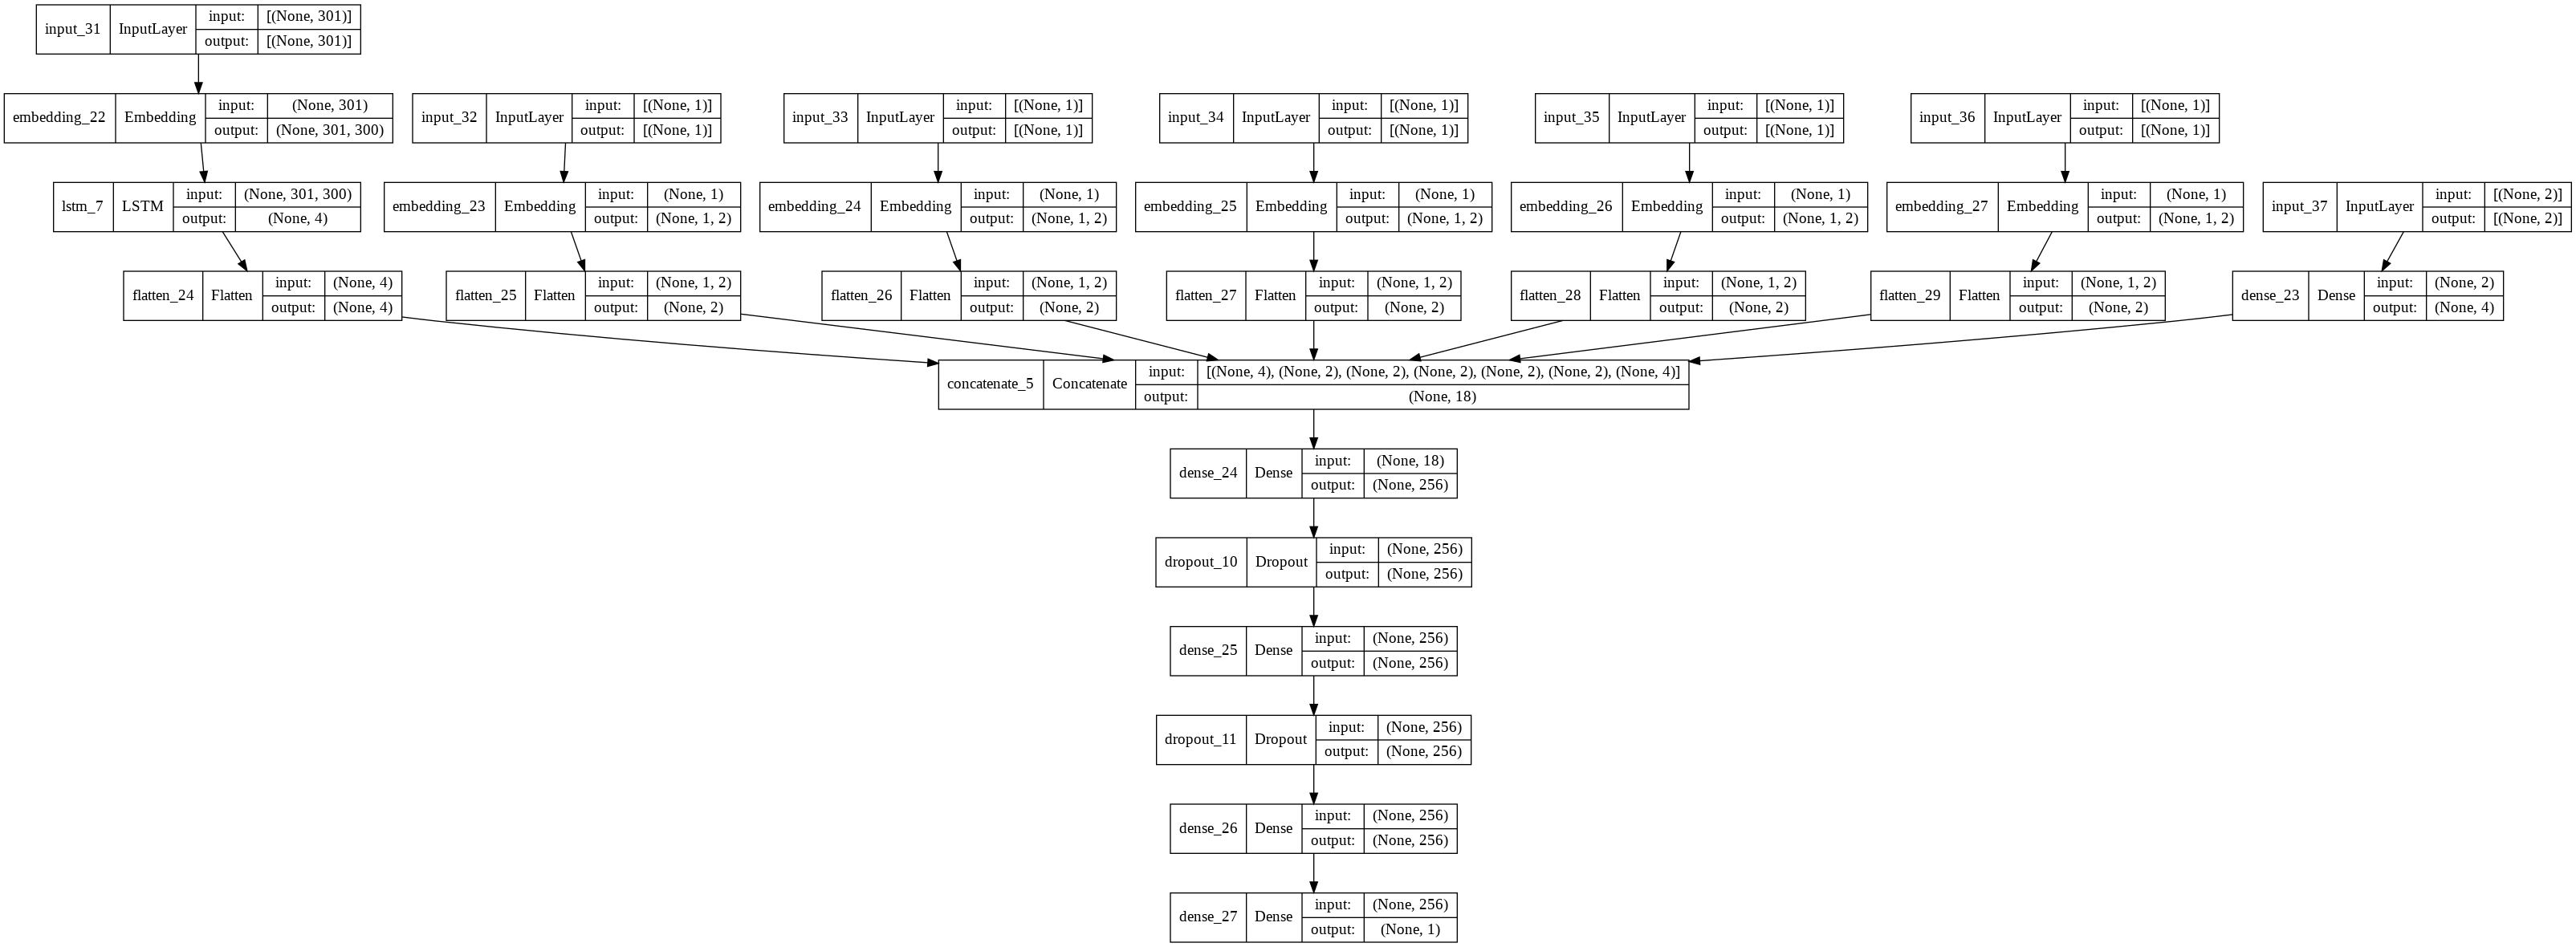

In [195]:
dot_img_file = 'model_2.png'
tf.keras.utils.plot_model(model_2, to_file=dot_img_file, show_shapes=True)

In [196]:
#custom auc metric
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.double)

In [201]:
#compile & fit the model
train_data = [train_padded_docs,column_train_data[:,0],column_train_data[:,2],column_train_data[:,3],column_train_data[:,4],column_train_data[:,1],numerical_data_train]
val_data = [test_padded_docs,column_test_data[:,0],column_test_data[:,2],column_test_data[:,3],column_test_data[:,4],column_test_data[:,1],numerical_data_test]

filepath="model_save/best_model_2.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_auc',  verbose=1, save_best_only=True, mode='max')

log_dir="logs\\fit\\Model_2_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

model_2.compile(loss='binary_crossentropy', optimizer='Adam',metrics = [auc])
model_2.fit(train_data,y_train,epochs=3, validation_data=(val_data,y_test), batch_size=64, callbacks=[checkpoint,tensorboard_callback])

Epoch 1/3
1144/1144 [==============================] - ETA: 0s - loss: 0.4072 - auc: 0.6530
Epoch 00001: val_auc improved from -inf to 0.72803, saving model to model_save/best_model_2.hdf5
1144/1144 [==============================] - 211s 182ms/step - loss: 0.4072 - auc: 0.6530 - val_loss: 0.3771 - val_auc: 0.7280
Epoch 2/3
1144/1144 [==============================] - ETA: 0s - loss: 0.3776 - auc: 0.7333
Epoch 00002: val_auc improved from 0.72803 to 0.74104, saving model to model_save/best_model_2.hdf5
1144/1144 [==============================] - 203s 178ms/step - loss: 0.3776 - auc: 0.7333 - val_loss: 0.3724 - val_auc: 0.7410
Epoch 3/3
1144/1144 [==============================] - ETA: 0s - loss: 0.3710 - auc: 0.7482
Epoch 00003: val_auc improved from 0.74104 to 0.74736, saving model to model_save/best_model_2.hdf5
1144/1144 [==============================] - 203s 178ms/step - loss: 0.3710 - auc: 0.7482 - val_loss: 0.3715 - val_auc: 0.7474


Observations:
1. Train auc improved a lot in just 3 epochs
2. val_auc reached high enough scores in the 1st epoch and did not change much in the subsequent epochs.
3. Best val_auc score is 0.7474
4. val_loss is 0.3715
5. The model is not overfitting

# <font color='red'> Model-3 </font>

In [ ]:
#vectorization of texts, same as model 1
vocab_size,pad_length,train_padded_docs,test_padded_docs,tokenizer = vectorization(X_train['essay'].values,X_test['essay'].values)

In [120]:
#one-hot encoding
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse

one_hot = OneHotEncoder(handle_unknown='ignore')
column_train_data = one_hot.fit_transform(X_train[['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories']])

column_test_data = one_hot.transform(X_test[['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories']])

In [198]:
#Standardizing the numerical data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_data_train = scaler.fit_transform(X_train[['teacher_number_of_previously_posted_projects','price']])
numerical_data_train = sparse.csr_matrix(numerical_data_train)

numerical_data_test = scaler.transform(X_test[['teacher_number_of_previously_posted_projects','price']])
numerical_data_test = sparse.csr_matrix(numerical_data_test)

In [174]:
#stacking categorical and numerical datasets together
other_than_text_data_train = sparse.hstack([column_train_data,numerical_data_train])
other_than_text_data_length = other_than_text_data_train.shape[1]

other_than_text_data_test = sparse.hstack([column_test_data,numerical_data_test])

In [175]:
#conversion from sparse array to dense array
other_than_text_data_train = other_than_text_data_train.toarray()
other_than_text_data_test = other_than_text_data_test.toarray()

In [176]:
#coversion from 2D to 3D
other_than_text_data_train = other_than_text_data_train[ : ,:,np.newaxis]
other_than_text_data_test = other_than_text_data_test[ : ,:,np.newaxis]

In [239]:
#shape of non text data
other_than_text_data_train.shape

(73196, 497, 1)

In [243]:
# defining input dimensions for the Conv1D layer
steps = other_than_text_data_train.shape[1]
input_dim = other_than_text_data_train.shape[2]

In [183]:
#defining model 3
inputs_text = Input(shape=(pad_length,))
embedding_text = Embedding(vocab_size+1, embedding_output,weights=[embedding_matrix_model_1],trainable=False)(inputs_text)
lstm = LSTM(4)(embedding_text)
flat_text = Flatten()(lstm)

inputs_non_text = Input(shape=(steps,input_dim))
conv11 = Conv1D(filters=16, kernel_size=2, activation='relu')(inputs_non_text)
conv12 = Conv1D(filters=16, kernel_size=2, activation='relu')(conv11)
flat_non_text = Flatten()(conv12)

concat = concatenate([flat_text, flat_non_text])

dense1 = Dense(256, activation='relu')(concat)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(256, activation='relu')(drop1)
drop2 = Dropout(0.5)(dense2)
dense3 = Dense(256, activation='relu')(drop2)

outputs = Dense(1, activation='sigmoid')(dense3)
model_3 = Model(inputs=[inputs_text,inputs_non_text], outputs=outputs)

In [185]:
#model summary
model_3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 339)]        0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 497, 1)]     0           []                               
                                                                                                  
 embedding_21 (Embedding)       (None, 339, 300)     14480400    ['input_29[0][0]']               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 496, 16)      48          ['input_30[0][0]']               
                                                                                            

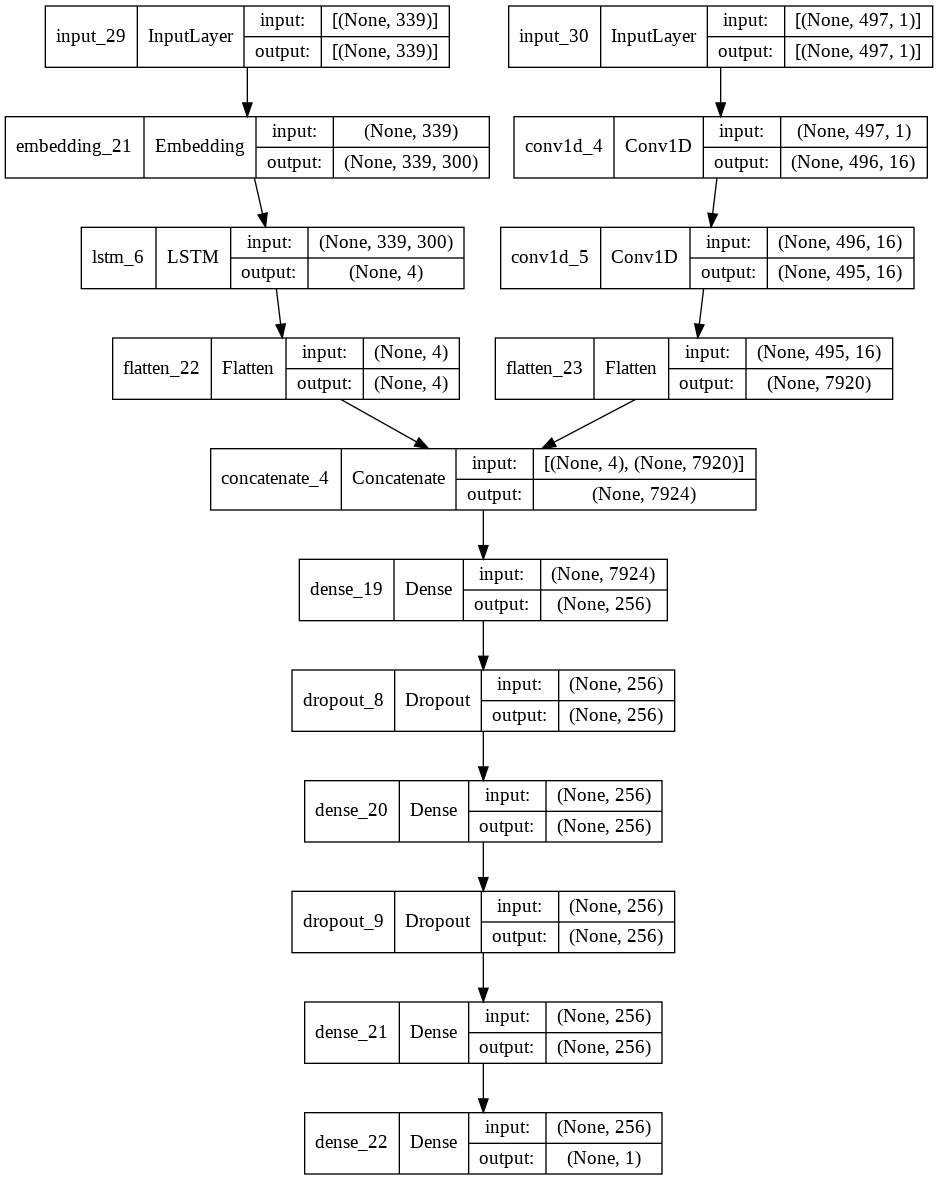

In [186]:
dot_img_file = 'model_3.png'
tf.keras.utils.plot_model(model_3, to_file=dot_img_file, show_shapes=True)

In [159]:
#custom auc metric
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.double)

In [184]:
#compile & fit the model
train_data = [train_padded_docs,other_than_text_data_train]
val_data = [test_padded_docs,other_than_text_data_test]

filepath="model_save/best_model_3.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_auc',  verbose=1, save_best_only=True, mode='max')

log_dir="logs\\fit\\Model_3_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)


model_3.compile(loss='binary_crossentropy', optimizer='Adam',metrics = [auc])
model_3.fit(train_data,y_train,epochs=3, validation_data=(val_data,y_test), batch_size=64, callbacks=[checkpoint,tensorboard_callback])

Epoch 1/3
1144/1144 [==============================] - ETA: 0s - loss: 0.4021 - auc: 0.6691
Epoch 00001: val_auc improved from -inf to 0.74021, saving model to model_save/best_model_3.hdf5
1144/1144 [==============================] - 264s 228ms/step - loss: 0.4021 - auc: 0.6691 - val_loss: 0.3732 - val_auc: 0.7402
Epoch 2/3
1144/1144 [==============================] - ETA: 0s - loss: 0.3760 - auc: 0.7375
Epoch 00002: val_auc improved from 0.74021 to 0.74728, saving model to model_save/best_model_3.hdf5
1144/1144 [==============================] - 263s 230ms/step - loss: 0.3760 - auc: 0.7375 - val_loss: 0.3688 - val_auc: 0.7473
Epoch 3/3
1144/1144 [==============================] - ETA: 0s - loss: 0.3699 - auc: 0.7493
Epoch 00003: val_auc improved from 0.74728 to 0.75303, saving model to model_save/best_model_3.hdf5
1144/1144 [==============================] - 260s 227ms/step - loss: 0.3699 - auc: 0.7493 - val_loss: 0.3658 - val_auc: 0.7530


Observation:
1. Model 3 gave the best scores ,i.e 0.7530
2. This also took 3 epochs
3. val_loss is 0.3658
4. This model is also not overfitting